## Packages

In [87]:
# ----- Tensorflow -----
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import regularizers as reg
from keras import optimizers
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

from keras.layers import Input, Dropout, Dense, Conv2D, MaxPooling2D, Flatten, Concatenate, AveragePooling2D, Rescaling

# ----- Utility functions -----
from utils import load_data, plot_hist

## Load Data

In [88]:
data_dir = 'C:/Users/chrse/Desktop/project_aml'
BATCH_SIZE = 32
train, test, val = load_data(data_dir, perc=1, batch_size=BATCH_SIZE)

### Architectures
Before we begin building complex architectures for the CNN model, we must establish a baseline classifier which we will attempt to beat. This common-sense baseline will tell us if we are moving in the right direction. In our case, we can choose a simple random classifier with a threshold of 0.5 since we have a binary classification problem where half of the samples belong to class A and the remaining 50% belong to class B. We could also specify a 'simple' machine learning algorithm as a baseline, but although we do not do this explicitly, we will aim to beat the trained models in question 1 as CNNs has some properties that make them superior to non-deep learning algorithms and feedforward neural networks (Chollet, 2021).

At this point, the first thing we want to achieve is statistical power, i.e. to cross the threshold of our baseline classifier by developing a small model. To do so, we focus on parameters such as the loss function, batch_size, learning rate, etc. Due to the way we represent the labels, we will use the softmax activation and the loss function categorical cross entropy rather than sigmoid and binary cross entropy, however, this will not change the results of our models.

Kommentar: Husk arkitektur (størrelse/bredde) og default valg af optimizer (adam) + valgte parametre = default settings + FLOW CHART

In [89]:
# ----- Relatively Simple Convnet from DLPR -----
inputs = Input(shape=(96, 96, 3))
x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = Flatten()(x)
outputs = Dense(2, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)

# ----- Model summary -----
model.summary()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# ----- Configure model -----
model.compile(optimizer=opt,
			  loss='categorical_crossentropy',
			  metrics=['accuracy'])

# ----- Train model -----
history = model.fit(train,
					epochs = 30,
					validation_data= val)

# ----- Plot performance -----
plot_hist(history)

Model: "model_147"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_173 (InputLayer)      [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_896 (Conv2D)         (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_716 (MaxPooli  (None, 47, 47, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_897 (Conv2D)         (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_717 (MaxPooli  (None, 22, 22, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_898 (Conv2D)         (None, 20, 20, 128)       73

KeyboardInterrupt: 

## Evaluation of simple model

The first results from the experiment with the simple model shows a promising accuracy of 83.xx%, which is significantly higher than the random classifier that has the expected prediction of 50/50. Futhermore, the plots of the accuracy over 30 epochs shows a rather fluctuating accuracy score, which could be an indication of a learning rate that is too high. Thus, for the next step in the procedure, we adjust the learning rate aswell as trying a setting with Stochastic Gradient Descent (SGD) as an alternative optimizer.

According to Goodfellow et al. (2016) perhaps the most important hyperparameter is the learning rate, and if we only had time to tune a single parameter, it should be this one (p. 424). The learning rate controls the speed of the gradient descent process, i.e. how much to adjust the parameters in a single step (Chollet, 2021). If the learning rate is too small, results in too many iterations and the possibility of getting stuck at a local minimum. In contrary, too high of a learning rate could result in divergent behavior. Therefore, we try different values of the learning rate using the Adam optimizer. Due to time constraints of training with different optimizers and learning rates, we will only compare the Adam and (SGD) from Keras. This is reasonable because one... adaptive vs SGD

In [90]:
## Hyperparameters for tuning learning rate and optimizer

learning_rates = [0.01, 0.001, 0.0001, 0.00001]
momentum = [0.99, 0.9]
nesterov = [True, False]

## Optimizer: Adam

Learning rate:  0
Epoch 1/50
82/82 [==============================] - 19s 219ms/step - loss: 1.2883 - accuracy: 0.4891 - val_loss: 0.6936 - val_accuracy: 0.4451
Epoch 2/50
82/82 [==============================] - 18s 213ms/step - loss: 0.6939 - accuracy: 0.4853 - val_loss: 0.6931 - val_accuracy: 0.5549
Epoch 3/50
82/82 [==============================] - 18s 213ms/step - loss: 0.6940 - accuracy: 0.4884 - val_loss: 0.6931 - val_accuracy: 0.5549
Epoch 4/50
82/82 [==============================] - 18s 213ms/step - loss: 0.6940 - accuracy: 0.4884 - val_loss: 0.6931 - val_accuracy: 0.5549
Epoch 5/50
82/82 [==============================] - 18s 213ms/step - loss: 0.6940 - accuracy: 0.4884 - val_loss: 0.6931 - val_accuracy: 0.5549
Epoch 6/50
82/82 [==============================] - 18s 214ms/step - loss: 0.6940 - accuracy: 0.4884 - val_loss: 0.6932 - val_accuracy: 0.4451
Epoch 7/50
82/82 [==============================] - 18s 214ms/step - loss: 0.6940 - accuracy: 0.4884 - val_loss: 0.6932 - va

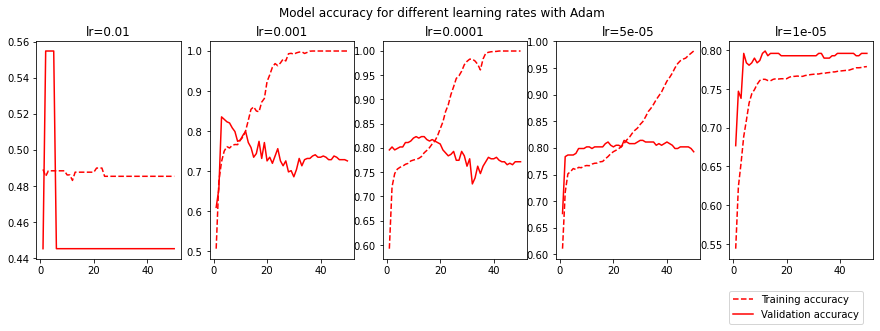

In [91]:
def simple_model():
	inputs = Input(shape=(96, 96, 3))
	x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
	x = MaxPooling2D(pool_size=2)(x)
	x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
	x = Flatten()(x)
	outputs = Dense(2, activation="softmax")(x)
	model = Model(inputs=inputs, outputs=outputs)

	return model

# ----- Define subplot grid -----
fig, axis = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))
plt.subplots_adjust(hspace=0.8)
fig.suptitle("Model accuracy for different learning rates with Adam", fontsize=12, y=1)

# Try different learning rates for Adam optimizer
for i in range(len(learning_rates)):
	opt = tf.keras.optimizers.Adam(learning_rate=learning_rates[i])

	current_model = simple_model()

	print('Learning rate: ', i)

	# ----- Configure model -----
	current_model.compile(optimizer=opt,
			  	loss='categorical_crossentropy',
			  metrics=['accuracy'])

	# ----- Train model -----
	history = current_model.fit(train,
						epochs=50,
						validation_data=val)

	# ----- Plot performance -----
	acc = history.history['accuracy']
	val_acc = history.history['val_accuracy']
	epochs = range(1, len(acc) + 1)

	axis[i].plot(epochs, acc, 'r--', label='Training accuracy')
	axis[i].plot(epochs, val_acc, 'r', label='Validation accuracy')
	axis[i].set_title('lr='+str(learning_rates[i]))

plt.legend(loc=(0,-0.3))
plt.show()

Epoch 1/50
82/82 [==============================] - 19s 226ms/step - loss: 0.6893 - accuracy: 0.5273 - val_loss: 0.6776 - val_accuracy: 0.5518
Epoch 2/50
82/82 [==============================] - 18s 219ms/step - loss: 0.6985 - accuracy: 0.5044 - val_loss: 0.7018 - val_accuracy: 0.4451
Epoch 3/50
82/82 [==============================] - 18s 214ms/step - loss: 0.6954 - accuracy: 0.4994 - val_loss: 0.6908 - val_accuracy: 0.5549
Epoch 4/50
82/82 [==============================] - 17s 213ms/step - loss: 0.6951 - accuracy: 0.4788 - val_loss: 0.6940 - val_accuracy: 0.4451
Epoch 5/50
82/82 [==============================] - 17s 212ms/step - loss: 0.6946 - accuracy: 0.4983 - val_loss: 0.6971 - val_accuracy: 0.4451
Epoch 6/50
82/82 [==============================] - 18s 216ms/step - loss: 0.6946 - accuracy: 0.4845 - val_loss: 0.6994 - val_accuracy: 0.4451
Epoch 7/50
82/82 [==============================] - 17s 212ms/step - loss: 0.6948 - accuracy: 0.4929 - val_loss: 0.7000 - val_accuracy: 0.4451

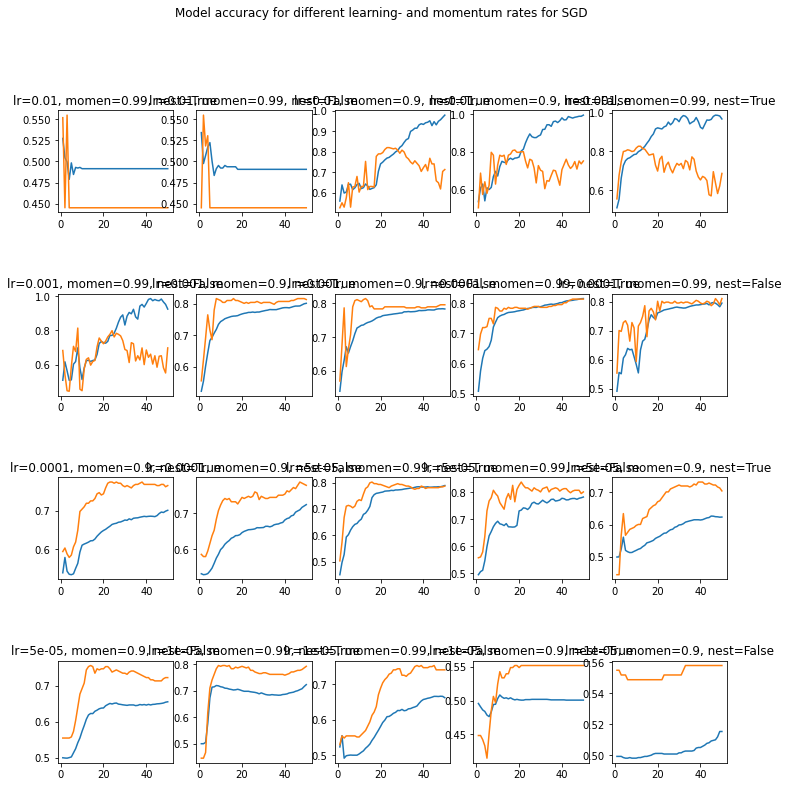

In [92]:
# ----- Define subplot grid -----
fig, axis = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
plt.subplots_adjust(hspace=0.8)
fig.suptitle("Model accuracy for different learning- and momentum rates for SGD", fontsize=12, y=1)

t=1
# Try different learning rates, momentum, and nesterov for SGD optimizer
for i in range(len(learning_rates)):
	for m in range(len(momentum)):
		for n in range(len(nesterov)):

			current_model = simple_model()

			opt = tf.keras.optimizers.SGD(learning_rate=learning_rates[i],
										  momentum=momentum[m],
										  nesterov=nesterov[n])

			# ----- Configure model -----
			current_model.compile(optimizer=opt,
						loss='categorical_crossentropy',
					metrics=['accuracy'])

			# ----- Train model -----
			history = current_model.fit(train,
								epochs=50,
								validation_data=val)

			# ----- Plot performance -----
			acc = history.history['accuracy']
			val_acc = history.history['val_accuracy']
			epochs = range(1, len(acc) + 1)

			axis = plt.subplot(4, 4, t)
			axis.plot(epochs, acc, label='Training accuracy')
			axis.plot(epochs, val_acc, label='Validation accuracy')
			axis.set_title('lr=' + str(learning_rates[i]) + ', momen=' + str(momentum[m]) + ', nest=' + str(nesterov[n]))
			t=t+1
#plt.legend(loc=(0,-0.3))
plt.show()

## Evaluation of learning rates and momentum for Adam and SGD



## Regularization 1: Adjustments to the architecture

- Add/remove layers
- Adjust number of nodes

In [61]:
inputs = Input(shape=(96, 96, 3))
x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = Flatten()(x)
outputs = Dense(2, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

# ----- Model summary -----
model.summary()
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
# ----- Configure model -----
model.compile(optimizer=opt,
			  loss='categorical_crossentropy',
			  metrics=['accuracy'])

# ----- Train model -----
history = model.fit(train,
					epochs = 30,
					validation_data= val)

# ----- Plot performance -----
plot_hist(history)


Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_62 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_335 (Conv2D)         (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_266 (MaxPooli  (None, 47, 47, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_336 (Conv2D)         (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_267 (MaxPooli  (None, 22, 22, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_337 (Conv2D)         (None, 20, 20, 128)       738

KeyboardInterrupt: 

Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_65 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_354 (Conv2D)         (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_282 (MaxPooli  (None, 48, 48, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_355 (Conv2D)         (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_283 (MaxPooli  (None, 24, 24, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_356 (Conv2D)         (None, 24, 24, 64)        184

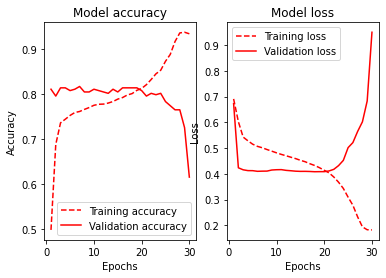

In [64]:
inputs = Input(shape=(96, 96, 3))
x = Conv2D(filters=16, kernel_size=3, activation="relu", padding='same')(inputs)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=32, kernel_size=3, activation="relu", padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu", padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=512, kernel_size=3, activation="relu", padding='same')(x)
x = Flatten()(x)

x = Dense(128, activation="relu")(x)
x = Dense(128, activation="relu")(x)
outputs = Dense(2, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

# ----- Model summary -----
model.summary()
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
# ----- Configure model -----
model.compile(optimizer=opt,
			  loss='categorical_crossentropy',
			  metrics=['accuracy'])

# ----- Train model -----
history = model.fit(train,
					epochs = 30,
					validation_data= val)

# ----- Plot performance -----
plot_hist(history)

## Regularization

Regarding early stopping, we prefer to save the best model instead and let the model train for the chosen epochs.

- L1/L2



# ----- Relatively Simple Convnet from DLPR -----
inputs = Input(shape=(96, 96, 3))
x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = Flatten()(x)
outputs = Dense(2, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)

# ----- Model summary -----
model.summary()

# ----- Configure model -----
model.compile(optimizer='adam',
			  loss='categorical_crossentropy',
			  metrics=['accuracy'])

# ----- Train model -----
history = model.fit(train,
					epochs = 2,
					validation_data= val)

# ----- Plot performance -----
plot_hist(history)

First model = Simple CNN from DLWP --> 